In [ ]:
!/opt/bin/nvidia-smi

Fri Dec  1 12:20:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
import os
from google.colab import drive

# Define transforms with data augmentation for training data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((56, 56)),  # Resize images to 56x56
        transforms.RandomHorizontalFlip(),  # Random horizontal flip
        transforms.RandomRotation(20),  # Random rotation
        transforms.ToTensor()  # Convert image to PyTorch Tensor data type
    ]),
    'val': transforms.Compose([
        transforms.Resize((56, 56)),  # Resize images to 56x56
        transforms.ToTensor()  # Convert image to PyTorch Tensor data type
    ]),
}

# Mount Google Drive
drive.mount('/content/drive')
root_path = '/content/drive/MyDrive/ODIR5K'

# Load the images from the different directories
dataset = ImageFolder(root_path, transform=data_transforms['train'])

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Apply different transformations to your training and validation sets
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch.nn.functional as F

# Define CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)  # Input channels = 3, output channels = 64
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 5)  # Input channels = 64, output channels = 128
        self.dropout = nn.Dropout(0.5)  # Dropout layer with dropout rate of 0.5
        self.fc1 = nn.Linear(128 * 11 * 11, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * 11 * 11)
        x = self.dropout(F.relu(self.fc1(x)))  # Apply Dropout after ReLU activation
        x = self.dropout(F.relu(self.fc2(x)))  # Apply Dropout after ReLU activation
        x = self.fc3(x)
        return x

Epoch: 1/100, Train Loss: 1.6261, Val Loss: 1.2133
Epoch: 2/100, Train Loss: 1.2770, Val Loss: 1.0978
Epoch: 3/100, Train Loss: 1.2147, Val Loss: 1.0831
Epoch: 4/100, Train Loss: 1.1496, Val Loss: 1.0877
Epoch: 5/100, Train Loss: 1.1116, Val Loss: 1.0776
Epoch: 6/100, Train Loss: 1.1184, Val Loss: 1.0528
Epoch: 7/100, Train Loss: 1.0861, Val Loss: 1.0727
Epoch: 8/100, Train Loss: 1.0830, Val Loss: 1.0394
Epoch: 9/100, Train Loss: 1.0519, Val Loss: 1.0473
Epoch: 10/100, Train Loss: 1.0362, Val Loss: 1.0134
Epoch: 11/100, Train Loss: 1.0003, Val Loss: 0.9733
Epoch: 12/100, Train Loss: 0.9861, Val Loss: 0.9695
Epoch: 13/100, Train Loss: 0.9962, Val Loss: 0.9612
Epoch: 14/100, Train Loss: 0.9790, Val Loss: 0.9546
Epoch: 15/100, Train Loss: 0.9660, Val Loss: 0.9539
Epoch: 16/100, Train Loss: 0.9597, Val Loss: 0.9820
Epoch: 17/100, Train Loss: 0.9881, Val Loss: 0.9469
Epoch: 18/100, Train Loss: 0.9734, Val Loss: 0.9607
Epoch: 19/100, Train Loss: 0.9703, Val Loss: 0.9406
Epoch: 20/100, Train 

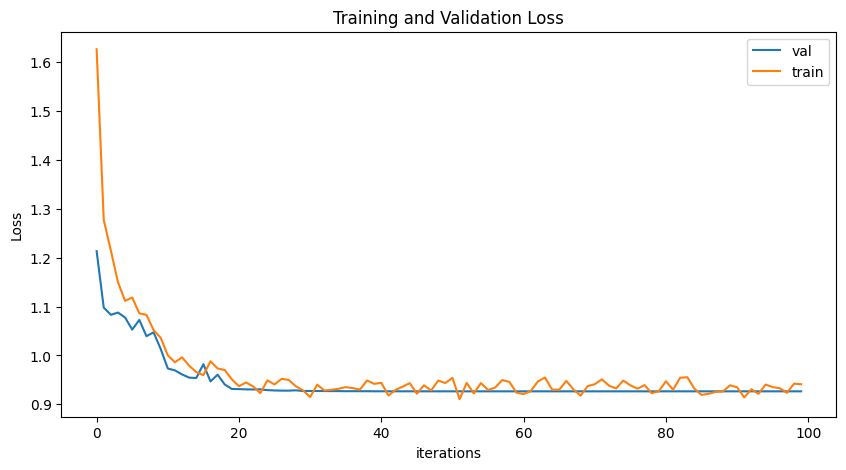

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce lr every 10 epochs

num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    # Step the scheduler
    scheduler.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Plot the training and validation loss
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model.eval()
val_preds = []
val_true = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        val_preds.extend(predicted.numpy().tolist())
        val_true.extend(labels.numpy().tolist())

f1 = f1_score(val_true, val_preds, average='weighted')
accuracy = accuracy_score(val_true, val_preds)

print(f'F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

F1 Score: 0.4559, Accuracy: 0.5556


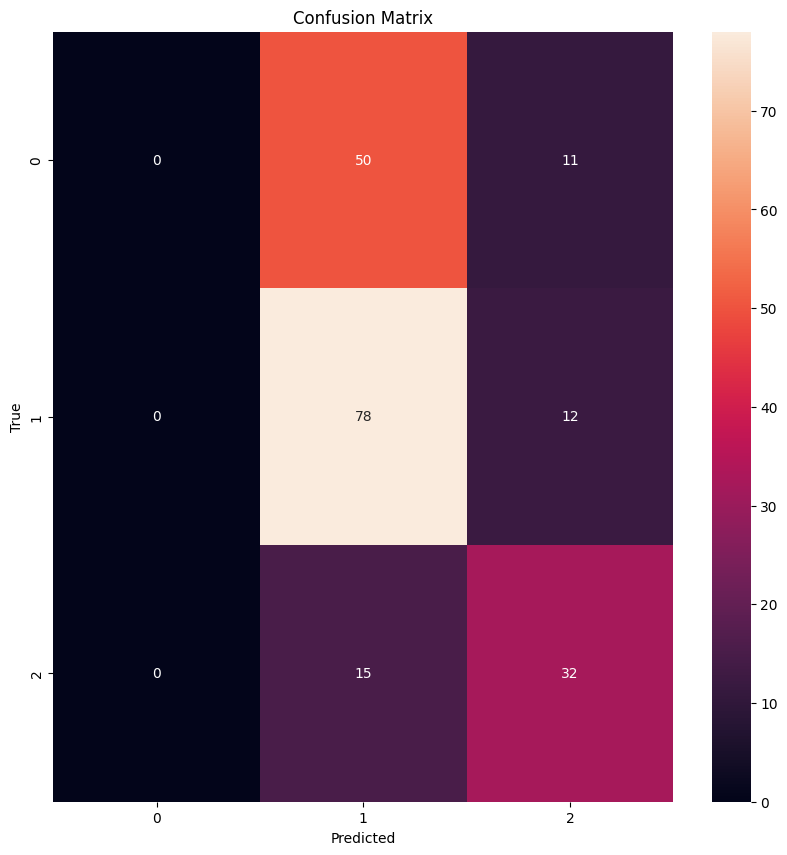

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Switch the model to evaluation mode
model.eval()

# Store all the true labels and the predicted labels
all_labels = []
all_preds = []

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels)
        all_preds.extend(predicted)

# Convert the lists to tensors
all_labels = torch.stack(all_labels)
all_preds = torch.stack(all_preds)

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()